In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, fft

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif",
})

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

xlabel_kwargs = {"fontsize":15}
ylabel_kwargs = {"fontsize":15}
legend_kwargs = {"fontsize":12}
title_kwargs = {"fontsize":18}

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.ae_v2 import Autoencoder

In [8]:
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)

if colab_flag == False:
    if strategy is None:
        # if gpus:
        #     gpu_to_use = 1
        tf.config.set_visible_devices([], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[]


2023-07-15 23:51:34.712853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 23:51:34.793152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 23:51:34.793423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 23:51:34.794761: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [9]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
2.8.1


# KS System

In [10]:
from numpy import *

data_dir_idx = '004'

dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data_og = fl['all_data'].astype(FTYPE)
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

num_params = params_mat.shape[1]
og_vars = all_data_og.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

normalize_flag_ogdata: False


In [11]:
FourierCoeffs = fft.fft(all_data_og[:, 0:og_vars], axis=1)
energySpectrum_og = FourierCoeffs.real**2 + FourierCoeffs.imag**2
energySpectrum_og = np.mean(energySpectrum_og, axis=0)

In [12]:
meancentereddata_og = all_data_og[:, 0:og_vars] - np.mean(all_data_og[:, 0:og_vars], axis=0)
covmat_og = np.matmul(meancentereddata_og.transpose(), meancentereddata_og) / (meancentereddata_og.shape[0] - 1)
eigvals_og = np.abs(np.linalg.eigvals(covmat_og))
eigvals_og = np.sort(eigvals_og)
eigvals_og = eigvals_og[::-1]

In [13]:
print('eigvals sum : ', np.sum(eigvals_og))
print('FC sum : ', np.sum(energySpectrum_og))

eigvals sum :  0.07060807617187499
FC sum :  7.090306647810429


In [14]:
dir_name_all_ae = os.getcwd()+'{ds}saved_ae'.format(ds=dir_sep)
# dir_contents_list = os.listdir(dir_name_all_ae)
# chosen_dir_list = []
# for elem in dir_contents_list:
#     dir_name_ae = dir_name_all_ae + dir_sep + elem
#     if os.path.isdir(dir_name_ae):
#         with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
#             lines = f.readlines()
#             params_dict = eval(''.join(lines))
#             if data_dir_idx == params_dict['data_dir_idx']:
#                 chosen_dir_list.append(elem)

chosen_dir_list = [
    'ae_005',
    'ae_006',
    'ae_007',
    'ae_008',
]
print('chosen_dir_list:', chosen_dir_list)

chosen_dir_list: ['ae_005', 'ae_006', 'ae_007', 'ae_008']


In [15]:
# making AR-RNN save directory
dir_name_aepod = os.getcwd() + dir_sep + 'saved_ae/ae_pod'
if not os.path.isdir(dir_name_aepod):
    os.makedirs(dir_name_aepod)

counter = 0
while True:
    dir_check = 'ae_pod_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_aepod + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_aepod = dir_name_aepod + dir_sep + dir_check
os.makedirs(dir_name_aepod)

dir_name_plot = dir_name_aepod+dir_sep+'plots'
os.makedirs(dir_name_plot)

In [16]:
print(dir_name_aepod)

/home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_pod/ae_pod_002


In [17]:
num_latent_states_list = []
timeAvgEnergySpectrum = []
covmat_list_AE = []
eigvals_list_AE = []
latent_states_covmat_list = []
latent_states_eigenvals_list = []

AE_recon_MSE_lst = []
AE_recon_RMSE_lst = []
AE_recon_NMSE_lst = []
AE_recon_NRMSE_lst = []

for elem in chosen_dir_list:
    time_taken = time.time()
    print('\n\n-------------------- {} --------------------'.format(elem))
    dir_name_ae = dir_name_all_ae + dir_sep + elem
    # reading simulation parameters
    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()
    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        ae_data_with_params = params_dict['ae_data_with_params']
    except:
        print("'ae_data_with_params' not present in ae_data, set to 'True'.")
        ae_data_with_params = True

    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
    
    # dealing with normalizing the data before feeding into autoencoder
    all_data = all_data_og
    if normalizeforae_flag == True:
        all_data = all_data_og.copy()
        for i in range(og_vars):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
    
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

    # create data
    latent_states_all = ae_net.encoder_net.predict(all_data)
    num_latent_states = latent_states_all.shape[1]
    num_latent_states_list.append(num_latent_states)

#     plot_latent_states_KS(
#         boundary_idx_arr,
#         latent_states_all,
#         delta_t,
#         dir_name_ae,
#         xticks_snapto=xticks_snapto,
#         num_yticks=11,
#         save_figs=False)
    
    reconstructed_data = ae_net.decoder_net.predict(latent_states_all)

#     plot_reconstructed_data_KS(
#         boundary_idx_arr,
#         dir_name_ae,
#         all_data,
#         reconstructed_data, delta_t, xgrid,
#         save_figs=False,
#         normalization_constant_arr=normalization_constant_arr_aedata,
#         xticks_snapto=xticks_snapto,
#         num_yticks=11)

    if normalizeforae_flag == True:
        for i in range(og_vars):
            reconstructed_data[:, i] *= normalization_constant_arr_aedata[1, i]
            reconstructed_data[:, i] += normalization_constant_arr_aedata[0, i]
            all_data[:, i] *= normalization_constant_arr_aedata[1, i]
            all_data[:, i] += normalization_constant_arr_aedata[0, i]

    FourierCoeffs = fft.fft(reconstructed_data[:, 0:og_vars], axis=1)
    energySpectrum = FourierCoeffs.real**2 + FourierCoeffs.imag**2
    energySpectrum = np.mean(energySpectrum, axis=0)
    timeAvgEnergySpectrum.append(energySpectrum)
    
    meancentereddata_ae = reconstructed_data[:, 0:og_vars] - np.mean(reconstructed_data[:, 0:og_vars], axis=0)
    covmat_ae = np.matmul(meancentereddata_ae.transpose(), meancentereddata_ae) / (meancentereddata_ae.shape[0] - 1)
    eigvals_ae = np.abs(np.linalg.eigvals(covmat_ae))
    eigvals_ae = np.sort(eigvals_ae)
    eigvals_ae = eigvals_ae[::-1]
    covmat_list_AE.append(covmat_ae)
    eigvals_list_AE.append(eigvals_ae)
    
    meancentered_ls = latent_states_all - np.mean(latent_states_all, axis=0)
    covmat_ls = np.matmul(meancentered_ls.transpose(), meancentered_ls) / (meancentered_ls.shape[0] - 1)
    eigvals_ls = np.abs(np.linalg.eigvals(covmat_ls))
    eigvals_ls = np.sort(eigvals_ls)
    eigvals_ls = eigvals_ls[::-1]
    latent_states_covmat_list.append(covmat_ls)
    latent_states_eigenvals_list.append(eigvals_ls)

    reconstruction_MSE = (reconstructed_data - all_data)**2
    stddev_all_data = np.std(all_data, axis=0)
    normalized_recon_MSE = np.average(reconstruction_MSE/stddev_all_data**2, axis=1)
    normalized_recon_RMSE = np.average(normalized_recon_MSE**0.5, axis=0)
    normalized_recon_MSE = np.average(normalized_recon_MSE, axis=0)
    reconstruction_MSE = np.average(reconstruction_MSE, axis=1)
    reconstruction_RMSE = np.average(reconstruction_MSE**0.5, axis=0)
    reconstruction_MSE = np.average(reconstruction_MSE, axis=0)
    
    AE_recon_MSE_lst.append(reconstruction_MSE)
    AE_recon_RMSE_lst.append(reconstruction_RMSE)
    AE_recon_NMSE_lst.append(normalized_recon_MSE)
    AE_recon_NRMSE_lst.append(normalized_recon_RMSE)
    
    del(latent_states_all)
    del(reconstructed_data)
    
    time_taken = time.time() - time_taken
    print('time_taken : {:02d}h {:02d}m {:02d}s'.format(
        int(time_taken//3600),
        int((time_taken%3600)//60),
        int(time_taken%60),
    ))



-------------------- ae_005 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
time_taken : 00h 00m 18s


-------------------- ae_006 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
time_taken : 00h 00m 18s


-------------------- ae_007 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
time_taken : 00h 00m 19s


-------------------- ae_008 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
time_taken : 00h 00m 18s


In [18]:
sorted_idx = np.argsort(num_latent_states_list)
num_latent_states_list = np.array(num_latent_states_list)[sorted_idx]
timeAvgEnergySpectrum = np.array(timeAvgEnergySpectrum)[sorted_idx, :]
covmat_list_AE = np.array(covmat_list_AE)[sorted_idx, :]
eigvals_list_AE = np.array(eigvals_list_AE)[sorted_idx, :]
chosen_dir_list = np.array(chosen_dir_list)[sorted_idx]
AE_recon_MSE_lst = np.array(AE_recon_MSE_lst)[sorted_idx]
AE_recon_RMSE_lst = np.array(AE_recon_RMSE_lst)[sorted_idx]
AE_recon_NMSE_lst = np.array(AE_recon_NMSE_lst)[sorted_idx]
AE_recon_NRMSE_lst = np.array(AE_recon_NRMSE_lst)[sorted_idx]

temp1 = []
temp2 = []
for i in range(len(sorted_idx)):
    temp1.append(latent_states_covmat_list[sorted_idx[i]])
    temp2.append(latent_states_eigenvals_list[sorted_idx[i]])
latent_states_covmat_list = temp1
latent_states_eigenvals_list = temp2

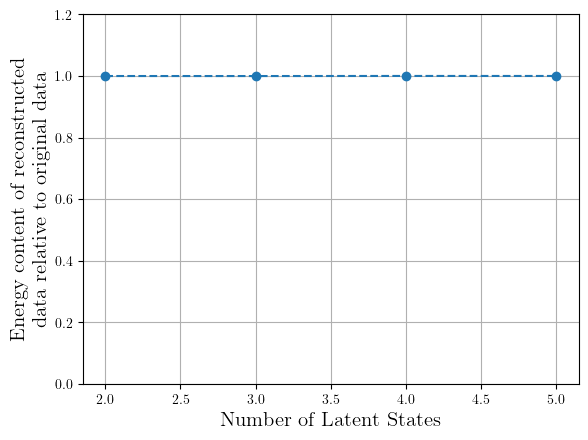

[0.99986438 0.99978539 1.00007242 0.99999993]


In [19]:
plt.plot(num_latent_states_list, np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), '--', marker='o')
plt.grid(True)
plt.xlabel('Number of Latent States', **xlabel_kwargs)
plt.ylabel('Energy content of reconstructed\ndata relative to original data', **xlabel_kwargs)
plt.ylim([0, 1.2])
plt.show()
print(np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og))

100.0
100.0
100.0
99.99999999999999


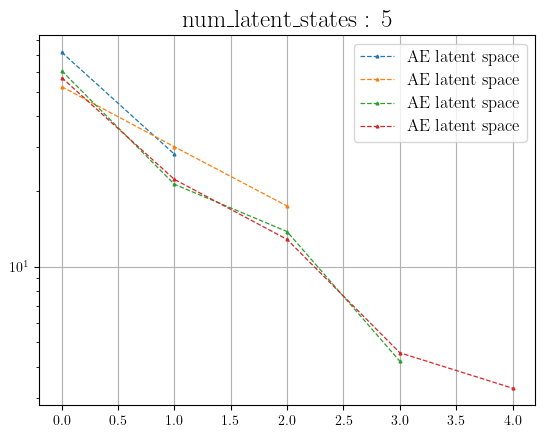

In [20]:
fig_eigvals, ax_eigvals = plt.subplots()
for i in range(len(chosen_dir_list)):
    # fig_eigvals, ax_eigvals = plt.subplots()
    # ax_eigvals.semilogy(eigvals_og/np.sum(eigvals_og), linestyle='--', marker='s', linewidth=0.9, markersize=2, label=r'Original Data')
    ax_eigvals.semilogy(100*latent_states_eigenvals_list[i]/np.sum(latent_states_eigenvals_list[i]), linestyle='--', marker='^', linewidth=0.9, markersize=2, label=r'AE latent space')
    idx_end = 19
    if len(latent_states_eigenvals_list[i]) < idx_end:
        idx_end = len(latent_states_eigenvals_list[i])
    print(100*np.sum(latent_states_eigenvals_list[i][0:idx_end]/np.sum(latent_states_eigenvals_list[i])))
        
ax_eigvals.grid(True)
ax_eigvals.legend(**legend_kwargs)
ax_eigvals.set_axisbelow(True)
ax_eigvals.set_title('Eigenvalues of the covariance matrix', **title_kwargs)
plt.title('num_latent_states : {}'.format(num_latent_states_list[i]), **title_kwargs)
plt.show()

In [21]:
with open(dir_name_aepod+'/chosen_dirs.txt', 'w') as f:
    s = 'dir_name, num_latent_states\n'#, enc_filters, dec_filters/n'
    f.write(s)
    for i in range(len(chosen_dir_list)):
        s = chosen_dir_list[i] + ', ' + str(num_latent_states_list[i]) + '\n'
        # s += ', ' + str(attention_used_list[i]) + ', ' + str(latent_states_shape_list[i]) + '\n'
        f.write(s)

# POD

In [22]:
# podcentering_means = np.empty(shape=numpoints_xgrid)
# for i in range(numpoints_xgrid):
#     podcentering_means[i] = np.mean(all_data_og[:, i])
#     all_data_og[:, i] -= podcentering_means[i]
# cov_matrix = all_data_og[:, 0:xgrid.shape[0]].transpose() @ all_data_og[:, 0:xgrid.shape[0]]
# cov_matrix /= all_data_og.shape[0]-1

podcentering_means = np.mean(all_data_og[:, 0:og_vars], axis=0)
meancentereddata_og = all_data_og[:, 0:og_vars] - podcentering_means
cov_matrix = np.matmul(meancentereddata_og.transpose(), meancentereddata_og)
cov_matrix /= meancentereddata_og.shape[0] - 1

In [23]:
eigenvals, eigenvecs = linalg.eig(cov_matrix)
sorted_idx = np.argsort(eigenvals)
eigenvals = eigenvals[sorted_idx]
eigenvecs = eigenvecs[:, sorted_idx]

In [24]:
for i in range(len(eigenvals)):
    ev = eigenvals[i]
    if ev < 0.0:
        print(i, ev)
#         eigenvals[i] *= -1
#         eigenvecs[:, i] *= -1
#         print(i, ev)

In [25]:
# sorted_idx = np.argsort(eigenvals)
# eigenvals = eigenvals[sorted_idx]
# eigenvecs = eigenvecs[:, sorted_idx]

In [26]:
# print(eigenvals)

# for i in range(eigenvecs.shape[1]):
#     print('norm(ev[:, {}]) : {}'.format(i, np.sum(eigenvecs[:, i]**2)))

In [27]:
pod_timeAvgEnergySpectrum = []
covmat_list_pod = []
eigvals_list_pod = []
POD_recon_MSE_lst = []
POD_recon_RMSE_lst = []
POD_recon_NMSE_lst = []
POD_recon_NRMSE_lst = []

stddev_all_data = np.std(all_data_og[:, 0:og_vars], axis=0)

for num_latent_states in num_latent_states_list:
    # num_latent_states = num_latent_states_list[i]
    Wl = eigenvecs[:, -num_latent_states:]
    Xl = (all_data_og[:, 0:og_vars]-podcentering_means) @ Wl @ Wl.transpose()
    for i in range(og_vars):
        Xl[:, i] += podcentering_means[i]
    FourierCoeffs = fft.fft(Xl, axis=1)
    energySpectrum = FourierCoeffs.real**2 + FourierCoeffs.imag**2
    energySpectrum = np.mean(energySpectrum, axis=0)
    pod_timeAvgEnergySpectrum.append(energySpectrum)
    
    meancentereddata_pod = Xl[:, 0:og_vars] - np.mean(Xl[:, 0:og_vars], axis=0)
    covmat_pod = np.matmul(meancentereddata_pod.transpose(), meancentereddata_pod) / (meancentereddata_pod.shape[0] - 1)
    eigvals_pod = np.abs(np.linalg.eigvals(covmat_pod))
    eigvals_pod = np.sort(eigvals_pod)
    eigvals_pod = eigvals_pod[::-1]
    covmat_list_pod.append(covmat_pod)
    eigvals_list_pod.append(eigvals_pod)
    
    reconstruction_MSE = (Xl[:, 0:og_vars] - all_data_og[:, 0:og_vars])**2
#     stddev_all_data = np.std(all_data_og, axis=0)
    normalized_recon_MSE = np.average(reconstruction_MSE/stddev_all_data**2, axis=1)
    normalized_recon_RMSE = np.average(normalized_recon_MSE**0.5, axis=0)
    normalized_recon_MSE = np.average(normalized_recon_MSE, axis=0)
    reconstruction_MSE = np.average(reconstruction_MSE, axis=1)
    reconstruction_RMSE = np.average(reconstruction_MSE**0.5, axis=0)
    reconstruction_MSE = np.average(reconstruction_MSE, axis=0)
    
    POD_recon_MSE_lst.append(reconstruction_MSE)
    POD_recon_RMSE_lst.append(reconstruction_RMSE)
    POD_recon_NMSE_lst.append(normalized_recon_MSE)
    POD_recon_NRMSE_lst.append(normalized_recon_RMSE)

# Comparison of Time Averaged RMSE

In [28]:
# save_dir = dir_name_all_ae+dir_sep+'PODvsAE'
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)

# counter = 0
# while True:
#     dir_check = 'PODvsAE_' + str(counter).zfill(3)
#     if os.path.isdir(save_dir + dir_sep + dir_check):
#         counter += 1
#     else:
#         break

# save_dir = save_dir + dir_sep + dir_check
# os.makedirs(save_dir)
# os.makedirs(save_dir+dir_sep+'plots')

# dirdict = {
#     'chosen_dir_list':chosen_dir_list,
#     'data_dir_idx':data_dir_idx,
# }
# with open(save_dir+dir_sep+'dirdict.txt', 'w') as f:
#     f.write(str(dirdict))

In [29]:
# plt.semilogy(num_latent_states_list, pod_RMSEavg_list, '--', marker='o')
# plt.semilogy(num_latent_states_list, ae_RMSEavg_list, '--', marker='o')
# plt.legend(['POD', 'AE'])
# plt.grid(True)
# plt.xlabel('Number of Latent States')
# plt.ylabel('Time Averaged RMSE')
# plt.title('Reconstruction Error vs. Number of Latent States', size=12)
# plt.savefig(save_dir+dir_sep+'plots'+dir_sep+'AE_vs_POD.png', dpi=300, bbox_inches='tight')
# plt.show()

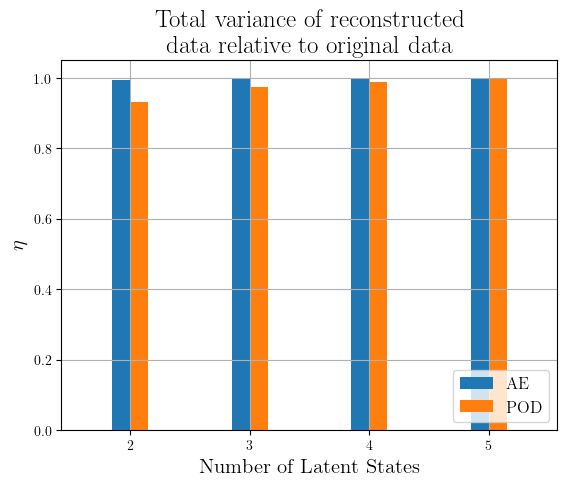

AE: [0.99309987 1.00003321 1.00000623 0.99933571]
POD: [0.93304225 0.9757836  0.98840731 0.99590938]


In [30]:
width = 0.15
ind = np.arange(num_latent_states_list.shape[0])

# plt.bar(ind, np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='AE')
# plt.bar(ind+width, np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='POD')
plt.bar(ind, np.sum(eigvals_list_AE, axis=1)/np.sum(eigvals_og), width, label='AE')
plt.bar(ind+width, np.sum(eigvals_list_pod, axis=1)/np.sum(eigvals_og), width, label='POD')
plt.grid(True)
plt.xlabel('Number of Latent States', **xlabel_kwargs)
# plt.ylabel('Energy content of reconstructed\ndata relative to original data', **ylabel_kwargs)
# plt.ylabel(
#     r'$ \sum_i \| \mathbf{x}(t_i) - \overline{\mathbf{x}} \|^2 \ / \ \sum_i \| \mathbf{x}^{i} - \overline{\mathbf{x}} \|^2$',
#     **ylabel_kwargs
# )
plt.ylabel('$\eta$', **ylabel_kwargs)
plt.title('Total variance of reconstructed\ndata relative to original data', **title_kwargs)
plt.xticks(ind+width/2, [r''+str(elem) for elem in num_latent_states_list])
# plt.ylim([-0.05, 1.05])
plt.xlim(-0.5, ind[-1]+width+0.5)
plt.legend(loc='lower right', **legend_kwargs)

plt.savefig(dir_name_plot+'/energy_content_AE_POD.pdf', dpi=300, bbox_inches='tight')
plt.show()

# print('AE:', np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og))
# print('POD:', np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og))
print('AE:', np.sum(eigvals_list_AE, axis=1)/np.sum(eigvals_og))
print('POD:', np.sum(eigvals_list_pod, axis=1)/np.sum(eigvals_og))

with open(dir_name_aepod+'/energy_content_AE_POD.txt', 'w') as f:
    s =  'num_latent_states : '
    temp_lst = ["{:02d}".format(elem) for elem in num_latent_states_list]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '               AE : '
    temp_lst = ["{:.4E} %".format(100*elem) for elem in np.sum(eigvals_list_AE, axis=1)/np.sum(eigvals_og)]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '              POD : '
    temp_lst = ["{:.4E} %".format(100*elem) for elem in np.sum(eigvals_list_pod, axis=1)/np.sum(eigvals_og)]
    s += ', '.join(temp_lst)
    s += "\n"
    f.write(s)

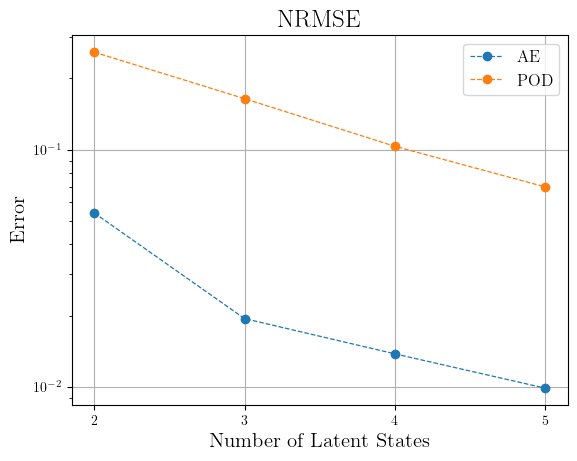

In [31]:
# reconstruction errors
error_type = 'NRMSE'
AE_error = eval('AE_recon_'+error_type+'_lst')
POD_error = eval('POD_recon_'+error_type+'_lst')

width = 0.15
ind = np.arange(num_latent_states_list.shape[0])

# plt.bar(ind, np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='AE')
# plt.bar(ind+width, np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='POD')
plt.semilogy(num_latent_states_list, AE_error, '--', marker='o', linewidth=0.9, label='AE')
plt.semilogy(num_latent_states_list, POD_error, '--', marker='o', linewidth=0.9, label='POD')
plt.grid(True)
plt.xlabel('Number of Latent States', **xlabel_kwargs)
plt.ylabel('Error', **ylabel_kwargs)
plt.title(error_type, **title_kwargs)
plt.xticks(num_latent_states_list, [r''+str(elem) for elem in num_latent_states_list])
# plt.ylim([-0.05, 1.05])
# plt.xlim(-0.5, ind[-1]+width+0.5)
plt.legend(**legend_kwargs)#loc='lower right')

plt.savefig(dir_name_plot+'/AE_POD_'+error_type+'.pdf', dpi=300, bbox_inches='tight')
plt.show()


with open(dir_name_aepod+'/AE_POD_'+error_type+'.txt', 'w') as f:
    s =  'num_latent_states : '
    temp_lst = ["{:02d}".format(elem) for elem in num_latent_states_list]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '               AE : '
    temp_lst = ["{:.4E}".format(elem) for elem in AE_error]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '              POD : '
    temp_lst = ["{:.4E}".format(elem) for elem in POD_error]
    s += ', '.join(temp_lst)
    s += "\n"
    f.write(s)

In [32]:
k = fft.fftfreq(og_vars, d=1/og_vars)
idx = np.where(k<0)[0]
k[idx] += og_vars
print(k)#*numpoints_xgrid*2*np.pi/xgrid[-1])

[0. 1. 2. 3. 4. 5.]


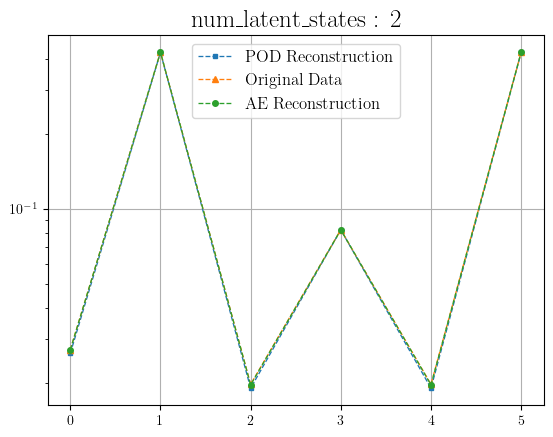

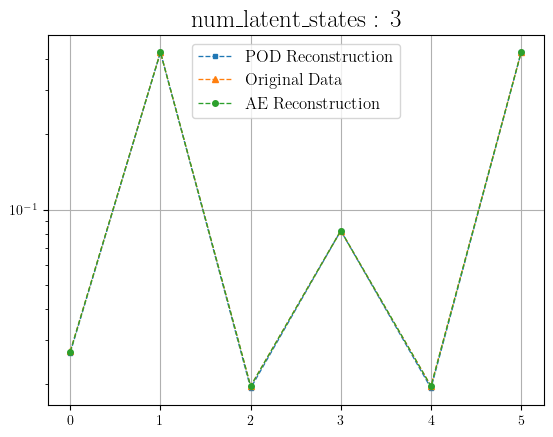

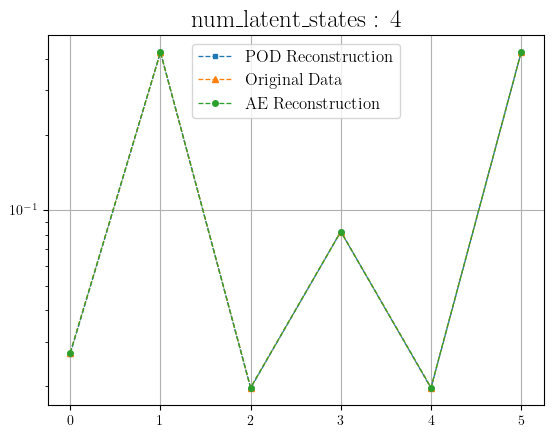

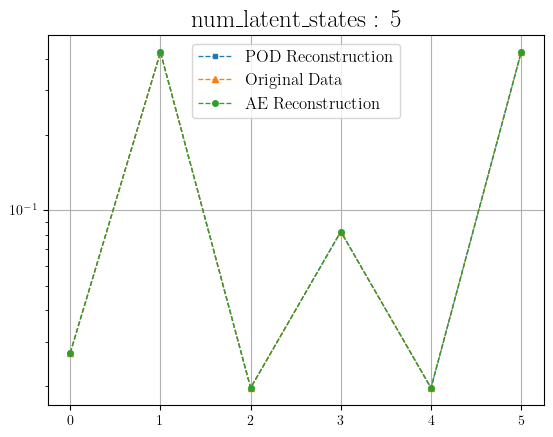

In [33]:
y1 = energySpectrum_og/np.sum(energySpectrum_og)
for i in range(len(chosen_dir_list)):
    y2 = timeAvgEnergySpectrum[i]/np.sum(energySpectrum_og)# np.sum(timeAvgEnergySpectrum[i])
    y3 = pod_timeAvgEnergySpectrum[i]/np.sum(energySpectrum_og)# np.sum(pod_timeAvgEnergySpectrum[i])
    plt.semilogy(k, y3, marker='s', markersize=3, linewidth=0.95, linestyle='--', label='POD Reconstruction')
    plt.semilogy(k, y1, marker='^', markersize=4, linewidth=0.95, linestyle='--', label='Original Data')
    plt.semilogy(k, y2, marker='o', markersize=4, linewidth=0.95, linestyle='--', label='AE Reconstruction')
    plt.title('num_latent_states : {}'.format(num_latent_states_list[i]), **title_kwargs)
    plt.grid(True)
    plt.legend(**legend_kwargs)
    plt.show()

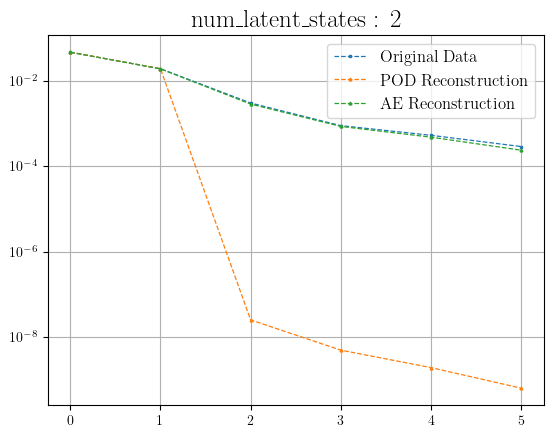

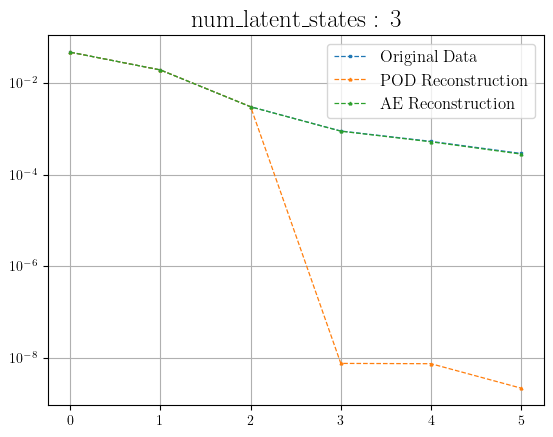

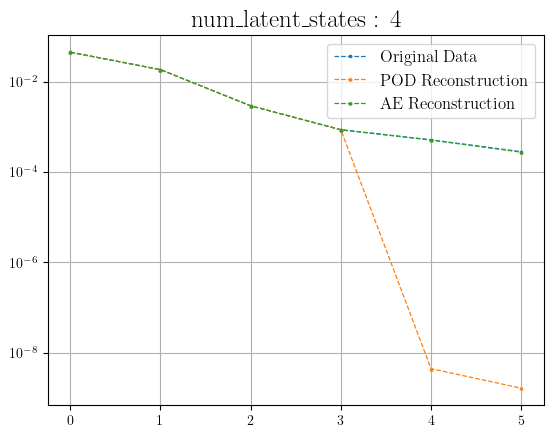

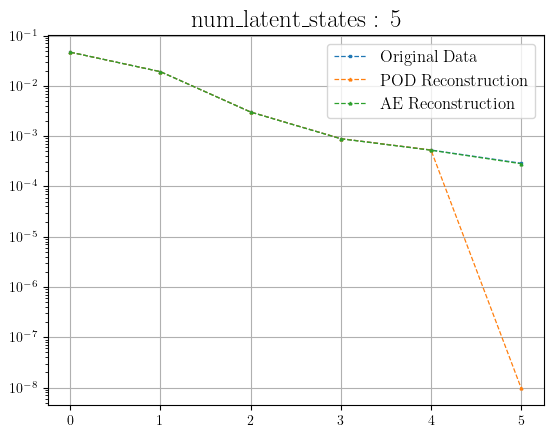

In [34]:
for i in range(len(chosen_dir_list)):
    fig_eigvals, ax_eigvals = plt.subplots()
    ax_eigvals.semilogy(eigvals_og, linestyle='--', marker='s', linewidth=0.9, markersize=2)
    ax_eigvals.semilogy(eigvals_list_pod[i], linestyle='--', marker='^', linewidth=0.9, markersize=2)
    ax_eigvals.semilogy(eigvals_list_AE[i], linestyle='--', marker='^', linewidth=0.9, markersize=2)
    ax_eigvals.grid(True)
    ax_eigvals.legend([r'Original Data', r'POD Reconstruction', r'AE Reconstruction'], **legend_kwargs)
    ax_eigvals.set_axisbelow(True)
    ax_eigvals.set_title('Eigenvalues of the covariance matrix', **title_kwargs)
    plt.title('num_latent_states : {}'.format(num_latent_states_list[i]), **title_kwargs)
    plt.show()

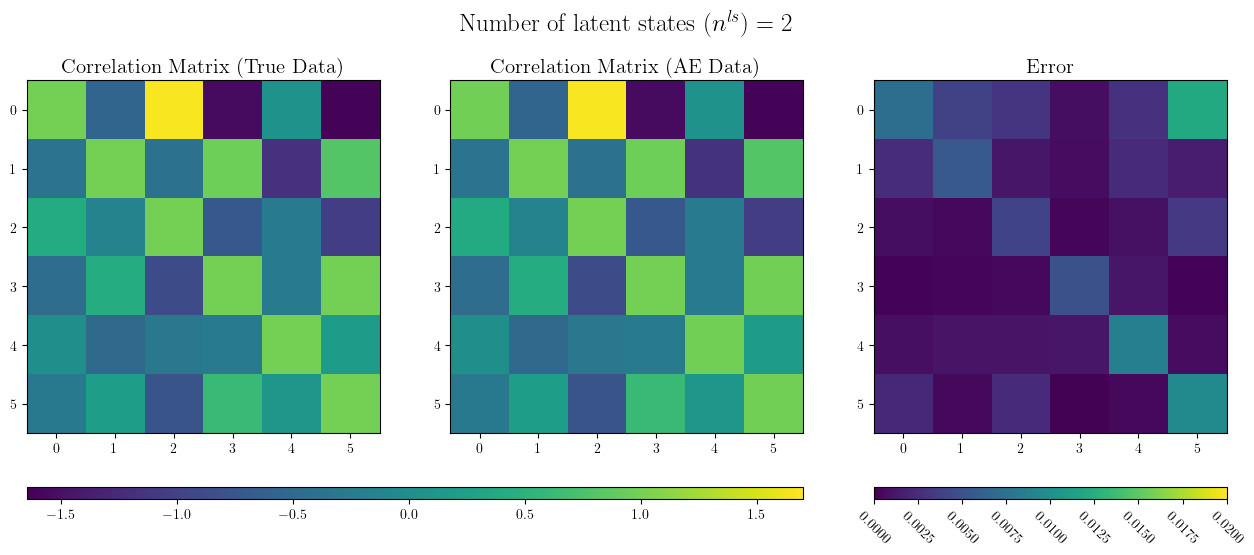

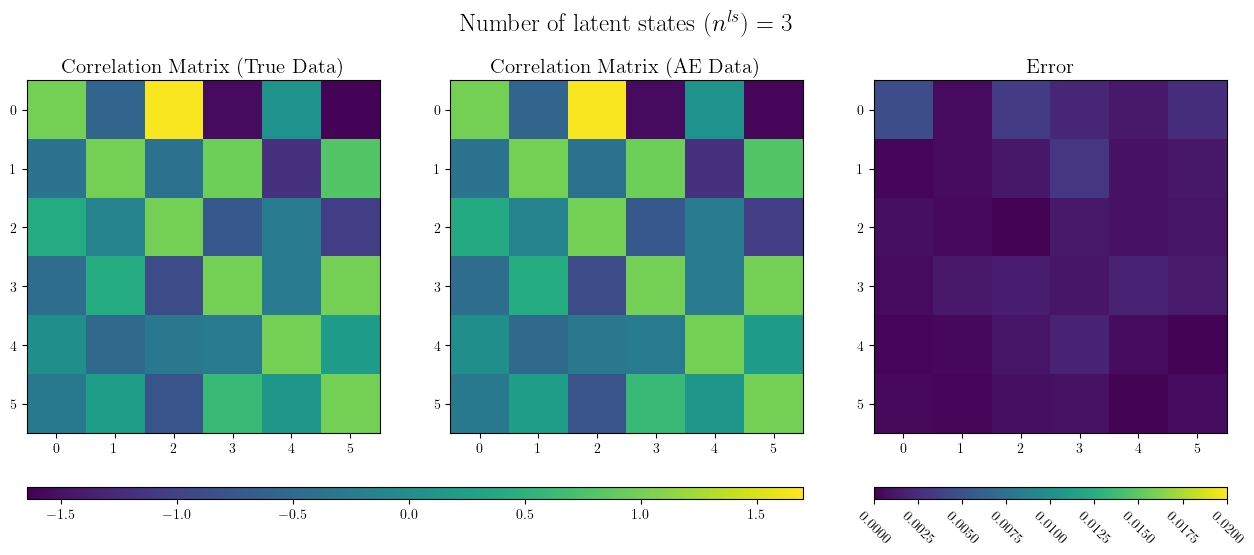

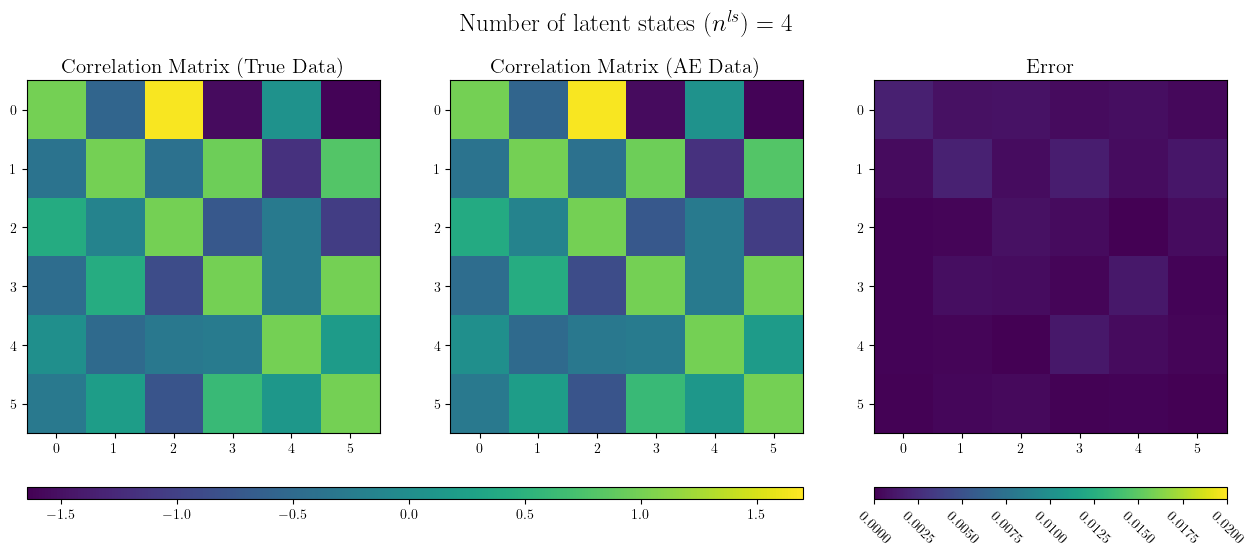

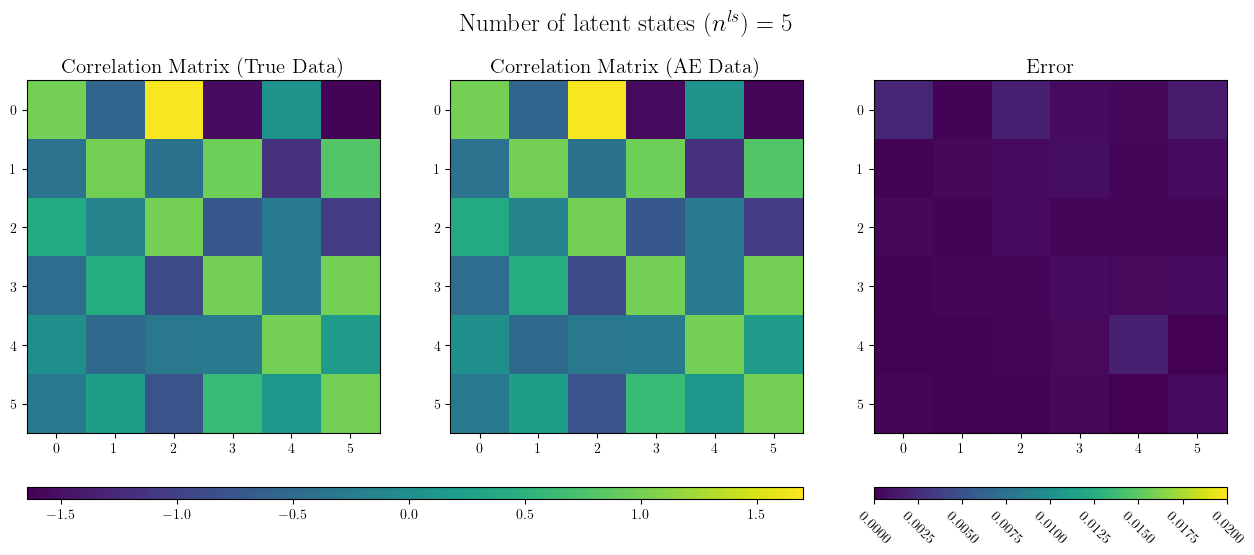

In [35]:
covmat_og_normd = np.divide(np.transpose(covmat_og), np.diag(covmat_og)).transpose()
for i in range(len(chosen_dir_list)):
    fig_covmat = plt.figure(figsize=(5.0*3, 5.0*1))
    subplot1 = 1
    subplot2 = subplot1 + 1
    
    covmat_ae_normd = np.divide(np.transpose(covmat_list_AE[i]), np.diag(covmat_og)).transpose()

    vmin_snap = 0.05
    vmax_snap = 0.05
    vmin = np.min([
        covmat_og_normd.min(),
        covmat_ae_normd.min()
    ])
    vmin = min(vmin, -1.0)
    vmin = -vmin_snap*np.round(-vmin/vmin_snap + 0.5)
    vmax = np.max([
        covmat_og_normd.max(),
        covmat_ae_normd.max()
    ])
    vmax = max(vmax, 1.0)
    vmax = vmax_snap*np.round(vmax/vmax_snap + 0.5)

    # plotting the original data
    ax_covmat_orig = fig_covmat.add_subplot(1, 3, subplot1)
    im_orig = ax_covmat_orig.imshow(
        covmat_og_normd,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_orig.set_title('Correlation Matrix (True Data)', **xlabel_kwargs)
    # xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
    # ax_covmat_orig.set_xticks(ticks=xticks)
    # ax_covmat_orig.set_xticklabels(np.round(xticks*delta_t, 1))
    # ax_covmat_orig.tick_params(axis='x', rotation=270+45)
    # yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
    # yticklabels = np.round(xgrid[0]+np.linspace(0, 1, yticks.shape[0])*(xgrid[-1]-xgrid[0]), 2)
    # ax_covmat_orig.set_yticks(ticks=yticks)
    # ax_covmat_orig.set_yticklabels(yticklabels)
    # ax_covmat_orig.set_xlabel(xlabel)
    # ax_covmat_orig.set_ylabel(ylabel)

    # plotting the predicted data
    ax_covmat_predict = fig_covmat.add_subplot(1, 3, subplot2, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_predict = ax_covmat_predict.imshow(
        covmat_ae_normd,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_predict.set_title('Correlation Matrix (AE Data)', **xlabel_kwargs)
    # ax_covmat_predict.tick_params(axis='x', rotation=270+45)
    # ax_covmat_predict.set_xlabel(xlabel)
    # ax_covmat_predict.set_ylabel(ylabel)

    # subplots adjustment to account for colorbars
    fig_covmat.subplots_adjust(
        bottom=0.1,
        left=0.1,
        top=1.0-0.13,
    )

    # original data and recon data colorbar
    cb_xbegin = ax_covmat_orig.transData.transform([-0.5, 0])
    cb_xbegin = fig_covmat.transFigure.inverted().transform(cb_xbegin)[0]
    cb_xend = ax_covmat_predict.transData.transform([covmat_ae_normd.shape[-1]-0.5, 0])
    cb_xend = fig_covmat.transFigure.inverted().transform(cb_xend)[0]

    cb_ax = fig_covmat.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
    cbar = fig_covmat.colorbar(im_predict, cax=cb_ax, orientation='horizontal')

    # computing the normalized error
    subplot3 = subplot2+1
    error = np.abs(covmat_og_normd-covmat_ae_normd)
    vmax_error_snap = 0.02
    vmax_error = np.max(error)
    vmax_error = vmax_error_snap*np.round(vmax_error/vmax_error_snap + 0.5)
    # error = 100*error / np.abs(pod_covmat_dataout)
    # plotting the normalized error
    ax_covmat_error = fig_covmat.add_subplot(1, 3, subplot3, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_error = ax_covmat_error.imshow(
        error,
        aspect='equal',
        origin='upper',
        vmin=0.0,
        vmax=vmax_error
    )
    ax_covmat_error.set_title(r'Error', **xlabel_kwargs)
    # ax_error.tick_params(axis='x', rotation=270+45)
    # ax_error.set_xlabel(xlabel)
    # ax_error.set_ylabel(ylabel)

    # error colorbar
    cbe_xbegin = ax_covmat_error.transData.transform([-0.5, 0])
    cbe_xbegin = fig_covmat.transFigure.inverted().transform(cbe_xbegin)[0]
    cbe_xend = ax_covmat_error.transData.transform([covmat_ae_normd.shape[-1]-0.5, 0])
    cbe_xend = fig_covmat.transFigure.inverted().transform(cbe_xend)[0]
    error_cb_ax = fig_covmat.add_axes([cbe_xbegin, 0.0, cbe_xend-cbe_xbegin, 0.025])
    error_cb_ax.tick_params(axis='x', rotation=270+45)
    cbar_error = fig_covmat.colorbar(im_error, cax=error_cb_ax, orientation='horizontal')

    fig_covmat.suptitle(
        r' Number of latent states $(n^{ls}) = ' + str(num_latent_states_list[i]) + '$',
        **title_kwargs
    )

    plt.savefig(dir_name_plot+'/covmat_error_AE_nls{}.pdf'.format(num_latent_states_list[i]), bbox_inches='tight', dpi=300)
    plt.show()

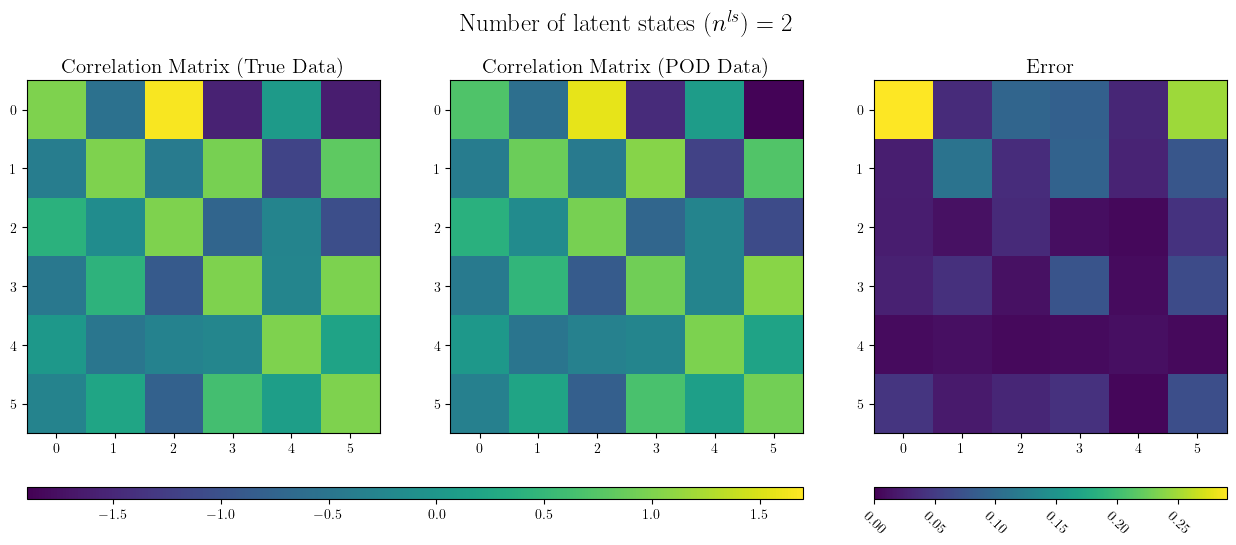

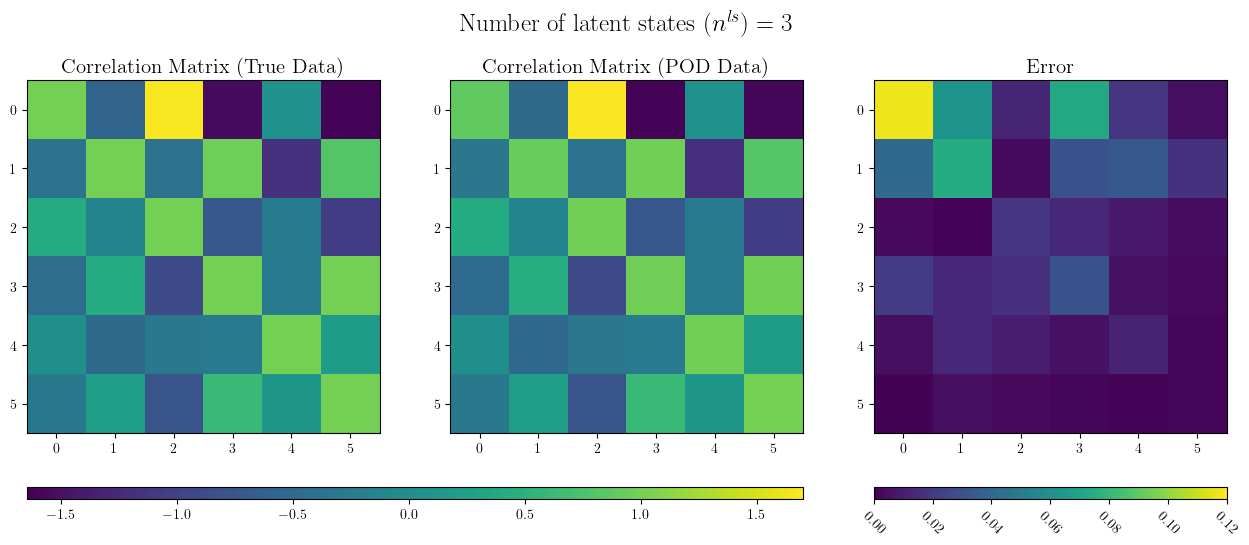

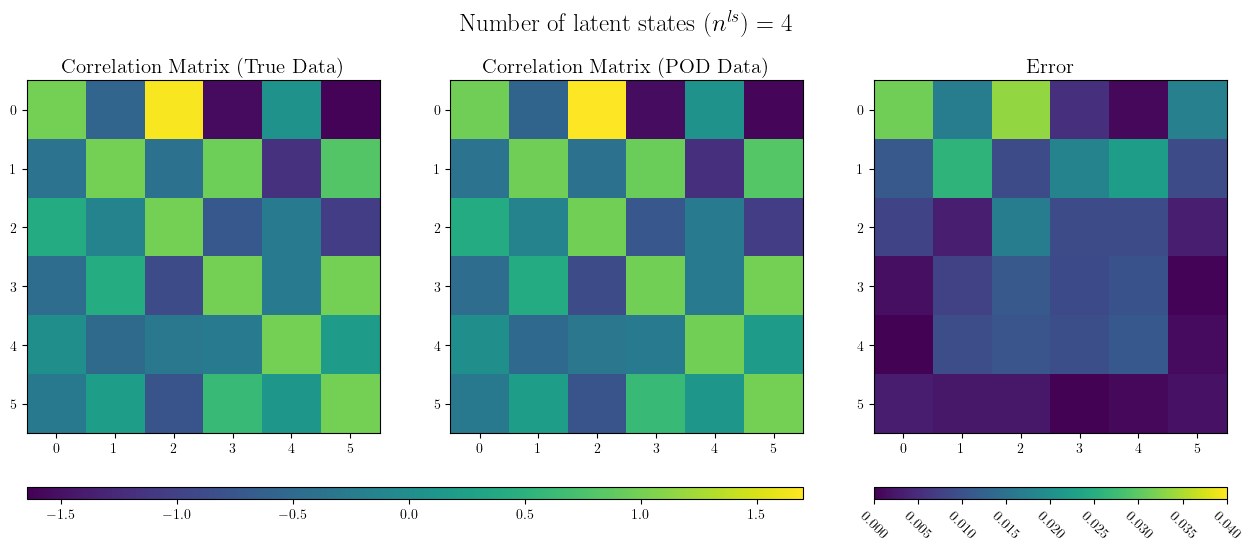

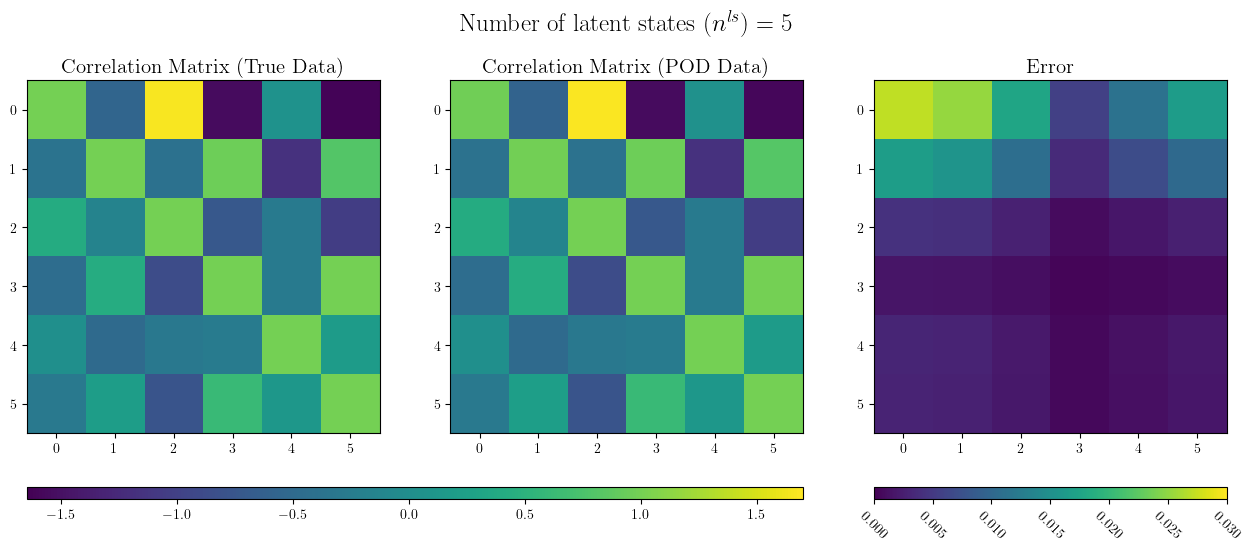

In [36]:
covmat_og_normd = np.divide(np.transpose(covmat_og), np.diag(covmat_og)).transpose()
for i in range(len(chosen_dir_list)):
    fig_covmat = plt.figure(figsize=(5.0*3, 5.0*1))
    subplot1 = 1
    subplot2 = subplot1 + 1
    
    covmat_pod_normd = np.divide(np.transpose(covmat_list_pod[i]), np.diag(covmat_og)).transpose()

    vmin_snap = 0.05
    vmax_snap = 0.05
    vmin = np.min([
        covmat_og_normd.min(),
        covmat_pod_normd.min()
    ])
    vmin = min(vmin, -1.0)
    vmin = -vmin_snap*np.round(-vmin/vmin_snap + 0.5)
    vmax = np.max([
        covmat_og_normd.max(),
        covmat_pod_normd.max()
    ])
    vmax = max(vmax, 1.0)
    vmax = vmax_snap*np.round(vmax/vmax_snap + 0.5)

    # plotting the original data
    ax_covmat_orig = fig_covmat.add_subplot(1, 3, subplot1)
    im_orig = ax_covmat_orig.imshow(
        covmat_og_normd,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_orig.set_title('Correlation Matrix (True Data)', **xlabel_kwargs)
    # xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
    # ax_covmat_orig.set_xticks(ticks=xticks)
    # ax_covmat_orig.set_xticklabels(np.round(xticks*delta_t, 1))
    # ax_covmat_orig.tick_params(axis='x', rotation=270+45)
    # yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
    # yticklabels = np.round(xgrid[0]+np.linspace(0, 1, yticks.shape[0])*(xgrid[-1]-xgrid[0]), 2)
    # ax_covmat_orig.set_yticks(ticks=yticks)
    # ax_covmat_orig.set_yticklabels(yticklabels)
    # ax_covmat_orig.set_xlabel(xlabel)
    # ax_covmat_orig.set_ylabel(ylabel)

    # plotting the predicted data
    ax_covmat_predict = fig_covmat.add_subplot(1, 3, subplot2, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_predict = ax_covmat_predict.imshow(
        covmat_pod_normd,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_predict.set_title('Correlation Matrix (POD Data)', **xlabel_kwargs)
    # ax_covmat_predict.tick_params(axis='x', rotation=270+45)
    # ax_covmat_predict.set_xlabel(xlabel)
    # ax_covmat_predict.set_ylabel(ylabel)

    # subplots adjustment to account for colorbars
    fig_covmat.subplots_adjust(
        bottom=0.1,
        left=0.1,
        top=1.0-0.13,
    )

    # original data and recon data colorbar
    cb_xbegin = ax_covmat_orig.transData.transform([-0.5, 0])
    cb_xbegin = fig_covmat.transFigure.inverted().transform(cb_xbegin)[0]
    cb_xend = ax_covmat_predict.transData.transform([covmat_pod_normd.shape[-1]-0.5, 0])
    cb_xend = fig_covmat.transFigure.inverted().transform(cb_xend)[0]

    cb_ax = fig_covmat.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
    cbar = fig_covmat.colorbar(im_predict, cax=cb_ax, orientation='horizontal')

    # computing the normalized error
    subplot3 = subplot2+1
    error = np.abs(covmat_og_normd-covmat_pod_normd)
    vmax_error_snap = 0.01
    vmax_error = np.max(error)
    vmax_error = vmax_error_snap*np.round(vmax_error/vmax_error_snap + 0.5)
    # error = 100*error / np.abs(pod_covmat_dataout)
    # plotting the normalized error
    ax_covmat_error = fig_covmat.add_subplot(1, 3, subplot3, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_error = ax_covmat_error.imshow(
        error,
        aspect='equal',
        origin='upper',
        vmin=0.0,
        vmax=vmax_error
    )
    ax_covmat_error.set_title(r'Error', **xlabel_kwargs)
    # ax_error.tick_params(axis='x', rotation=270+45)
    # ax_error.set_xlabel(xlabel)
    # ax_error.set_ylabel(ylabel)

    # error colorbar
    cbe_xbegin = ax_covmat_error.transData.transform([-0.5, 0])
    cbe_xbegin = fig_covmat.transFigure.inverted().transform(cbe_xbegin)[0]
    cbe_xend = ax_covmat_error.transData.transform([covmat_pod_normd.shape[-1]-0.5, 0])
    cbe_xend = fig_covmat.transFigure.inverted().transform(cbe_xend)[0]
    error_cb_ax = fig_covmat.add_axes([cbe_xbegin, 0.0, cbe_xend-cbe_xbegin, 0.025])
    error_cb_ax.tick_params(axis='x', rotation=270+45)
    cbar_error = fig_covmat.colorbar(im_error, cax=error_cb_ax, orientation='horizontal')

    fig_covmat.suptitle(
        r' Number of latent states $(n^{ls}) = ' + str(num_latent_states_list[i]) + '$',
        **title_kwargs
    )

    plt.savefig(dir_name_plot+'/covmat_error_POD_nls{}.pdf'.format(num_latent_states_list[i]), bbox_inches='tight', dpi=300)
    plt.show()